In [80]:
import numpy as np
import random
import plotly.express as px
import math
import plotly.graph_objects as go
import plotly.subplots as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

## BLACK JACK PROBLEM USING Monto Carlo ES

In the given problem description, it is mentioned that the states depend on three variables: the player's current sum (ranging from 12 to 21), the dealer's showing card (ranging from ace to 10), and whether or not the player holds a usable ace (0 or 1).

For the player's current sum, there are 10 possible values (12, 13, ..., 21).

For the dealer's showing card, there are 10 possible values (ace, 2, ..., 10).

For the usable ace, there are 2 possible values (0 or 1).

Therefore, the total number of possible states is: 10 * 10 * 2 = 200.

In [81]:
def NewCard():
    card = np.random.randint(1, 14)
    return card if card <=9 else 10

def GenerateInitState():
    player_sum = 0
    usable_ace = bool(np.random.randint(0,2))
    if usable_ace:
        x = NewCard()
        player_sum = 11 + x if x != 1 else 12
    else:
        x,y = NewCard(),NewCard()
        while x==1 or y == 1  or (x + y < 12):
            x,y = NewCard(),NewCard()
        player_sum = x + y
    dealer_card = NewCard()
    return player_sum,dealer_card,usable_ace

class Policy():
    def __init__(self) -> None:
        self.policy = {}
        self.q = {}
        self.count_pairs = {}
        self.poss_states = [(player_sum,dealer_card,usable_ace) for player_sum in range(12,22) for dealer_card in range(1,11) for usable_ace in [True,False]]
        self.num_states = len(self.poss_states)
        for state in self.poss_states:
            player_sum,_,_ = state
            self.policy[state] = False if player_sum in (20,21) else True
            self.q[(state,True)] = self.q[(state,False)] = self.count_pairs[(state,True)] = self.count_pairs[(state,False)] = 0
    
    def action(self,curr_state):
        return self.policy[curr_state]
    
    def EvaluateAndImprovePolicy(self,player_episode,reward):
        self.visitMap = set()
        for pair in player_episode:
            state,_ = pair
            if pair not in self.visitMap:
                self.visitMap.add(pair)
                self.count_pairs[pair] += 1
                self.q[pair] +=  (reward - self.q[pair])/self.count_pairs[pair]
                self.policy[state] = True if self.q[(state,True)] > self.q[(state,False)] else False

class Player():
    def __init__(self,player_sum,dealer_card,usable_ace,policy):
        self.sum = player_sum
        self.dealer_card = dealer_card
        self.usable_ace = usable_ace
        self.curr_state = (self.sum,self.dealer_card,self.usable_ace)
        self.policy = policy
        # self.episode = [self.curr_state]
        self.ExploringStart()

    def ExploringStart(self):
        rand_start = bool(np.random.randint(0,2)) # Hit or Stick
        self.episode = [(self.curr_state,rand_start)]
        if rand_start:
            self.Hit()
        self.stick = False if rand_start else True

    def ShouldHit(self):
        return self.policy.action(self.curr_state)
    
    def IsBust(self):
        if self.sum > 21:
            if self.usable_ace:
                self.sum -= 10
                self.usable_ace = False
                return self.IsBust()
            else:
                return True
        else:
            return False

    def Hit(self):
        next_card = NewCard()
        self.sum += next_card
        if self.IsBust():
            return 
        self.curr_state = (self.sum,self.dealer_card,self.usable_ace)
        self.episode.append((self.curr_state,self.ShouldHit()))
    
    def CreateEpisode(self):
        while not self.IsBust() and self.ShouldHit() and not self.stick:
            self.Hit()
        return self.episode
    
class Dealer():
    def __init__(self,dealer_card):
        self.cards = [dealer_card,NewCard()]
        self.usable_ace = True if 1 in self.cards else False
        self.sum = sum(self.cards)
        self.episode = [self.sum]

    def ShouldHit(self):
        return self.sum < 17
    
    def IsBust(self):
        if self.sum > 21:
            if self.usable_ace:
                self.sum -= 10
                self.usable_ace = False
                return self.IsBust()
            else:
                return True
        else:
            return False

    def Hit(self):
        next_card = NewCard()
        self.sum += next_card
        if self.IsBust():
            return 
        self.episode.append(self.sum)
    
    def CreateEpisode(self):
        while not self.IsBust() and self.ShouldHit():
            self.Hit()
        return self.episode

def computeReward(player,dealer):
    if player.IsBust():
        return -1
    elif dealer.IsBust() or player.sum > dealer.sum:
        return 1
    elif dealer.sum > player.sum:
        return -1
    else:
        return 0
    
class MontoCarloES():
    def __init__(self,max_iters):
        self.policy = Policy()
        self.max_iters = max_iters

    def run(self):
        for _ in tqdm(range(self.max_iters)):
            player_sum,dealer_card,usable_ace = GenerateInitState()
            player = Player(player_sum,dealer_card,usable_ace,self.policy)
            dealer = Dealer(dealer_card)
            pl_ep = player.CreateEpisode()
            dl_ep = dealer.CreateEpisode()
            self.policy.EvaluateAndImprovePolicy(pl_ep,computeReward(player,dealer))

    def plot_results(self):
        data_Ace = np.zeros((10,10))
        data_NoAce = np.zeros((10,10))
        for state in self.policy.poss_states:
            dealer_card_idx = state[1] - 1
            player_sum_idx = state[0] - 12
            if state[2]:
                data_Ace[dealer_card_idx,player_sum_idx,] = self.policy.action(state)
            else:
                data_NoAce[dealer_card_idx,player_sum_idx,] = self.policy.action(state)

        plt.figure(0)
        plt.title('With Usable Ace')
        for x in range(10):
            for y in range(10):
                plt.scatter(x,y,color='red') if data_Ace[x,y] else plt.scatter(x,y,color='blue')
        plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(10), [ '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.figure(1)
        plt.title('Without Usable Ace')
        for x in range(10):
            for y in range(10):
                plt.scatter(x,y,color='red') if data_NoAce[x,y] else plt.scatter(x,y,color='blue')
        plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(10), [ '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.show()

        return data_Ace,data_NoAce

100%|██████████| 2000000/2000000 [01:32<00:00, 21516.91it/s]


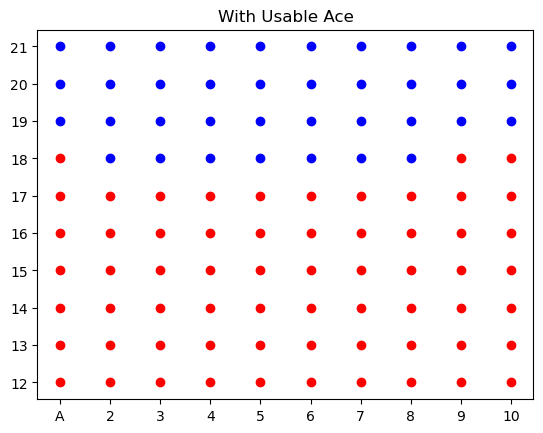

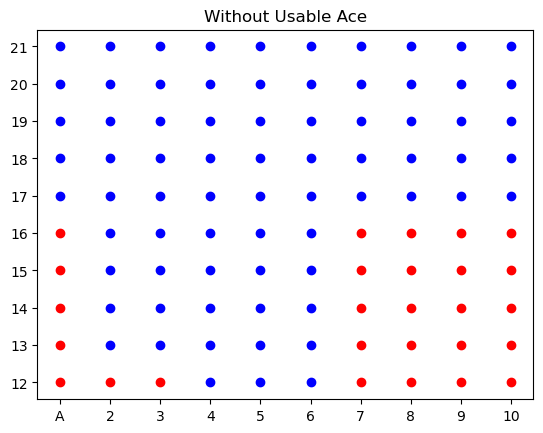

In [82]:
algo = MontoCarloES(2000000)
algo.run()
data_Ace,data_NoAce = algo.plot_results()

## BLACK JACK PROBLEM USING MONTO CARLO OFF POLICY USING WEIGHTED IMPORTANCE SAMPLING

In [75]:
def NewCard():
    card = np.random.randint(1, 14)
    return card if card <=9 else 10

def GenerateInitState():
    player_sum = 0
    usable_ace = bool(np.random.randint(0,2))
    if usable_ace:
        x = NewCard()
        player_sum = 11 + x if x != 1 else 12
    else:
        x,y = NewCard(),NewCard()
        while x==1 or y == 1  or (x + y < 12):
            x,y = NewCard(),NewCard()
        player_sum = x + y
    dealer_card = NewCard()
    return player_sum,dealer_card,usable_ace

class Policy():
    def __init__(self) -> None:
        self.policy = {}
        self.q = {}
        self.count_pairs = {}
        self.cum_weights = {}
        self.poss_states = [(player_sum,dealer_card,usable_ace) for player_sum in range(12,22) for dealer_card in range(1,11) for usable_ace in [True,False]]
        self.num_states = len(self.poss_states)
        for state in self.poss_states:
            player_sum,_,_ = state
            self.policy[state] = False if player_sum in (20,21) else True
            self.q[(state,True)] = self.q[(state,False)] = self.cum_weights[(state,True)] = self.cum_weights[(state,False)] = 0
    
    def action(self,curr_state):
        return self.policy[curr_state]
    
    def EvaluateAndImprovePolicy(self,player,reward):
        ep = player.episode
        G = reward
        W = 1
        for pair in reversed(ep):
            state,_ = pair
            self.cum_weights[pair] += W
            self.q[pair] +=  (W/self.cum_weights[pair])*(G - self.q[pair])
            W *= self.action(state)/0.5
            self.policy[state] = True if self.q[(state,True)] > self.q[(state,False)] else False
            if W == 0:
                break

class Player():
    def __init__(self,player_sum,dealer_card,usable_ace):
        self.sum = player_sum
        self.dealer_card = dealer_card
        self.usable_ace = usable_ace
        self.curr_state = (self.sum,self.dealer_card,self.usable_ace)
        self.episode = []

    def policy(self,state):
        return bool(np.random.binomial(1,0.5))

    def ShouldHit(self):
        return self.policy(self.curr_state)
    
    def IsBust(self):
        if self.sum > 21:
            if self.usable_ace:
                self.sum -= 10
                self.usable_ace = False
                return self.IsBust()
            else:
                return True
        else:
            return False

    def Hit(self):
        next_card = NewCard()
        self.sum += next_card
        self.episode.append((self.curr_state,self.hit))
        if self.IsBust():
            return 
        self.curr_state = (self.sum,self.dealer_card,self.usable_ace)
        
    
    def CreateEpisode(self):
        while not self.IsBust():
            self.hit = self.policy(self.curr_state)
            if self.hit:
                self.Hit()
            else: 
                self.episode.append((self.curr_state,self.hit))
                return
    
class Dealer():
    def __init__(self,dealer_card):
        self.cards = [dealer_card,NewCard()]
        self.usable_ace = True if 1 in self.cards else False
        self.sum = sum(self.cards)
        self.episode = [self.sum]

    def ShouldHit(self):
        return self.sum < 17
    
    def IsBust(self):
        if self.sum > 21:
            if self.usable_ace:
                self.sum -= 10
                self.usable_ace = False
                return self.IsBust()
            else:
                return True
        else:
            return False

    def Hit(self):
        next_card = NewCard()
        self.sum += next_card
        if self.IsBust():
            return 
        self.episode.append(self.sum)
    
    def CreateEpisode(self):
        while not self.IsBust() and self.ShouldHit():
            self.Hit()
        return self.episode

def computeReward(player,dealer):
    if player.IsBust():
        return -1
    elif dealer.IsBust() or player.sum > dealer.sum:
        return 1
    elif dealer.sum > player.sum:
        return -1
    else:
        return 0
    
class MontoCarlo_OffPolicy():
    def __init__(self,max_iters):
        self.policy = Policy()
        self.max_iters = max_iters

    def run(self):
        for _ in tqdm(range(self.max_iters)):
            player_sum,dealer_card,usable_ace = GenerateInitState()
            player = Player(player_sum,dealer_card,usable_ace)
            dealer = Dealer(dealer_card)
            player.CreateEpisode()
            dealer.CreateEpisode()
            self.policy.EvaluateAndImprovePolicy(player,computeReward(player,dealer))

    def plot_results(self):
        data_Ace = np.zeros((10,10))
        data_NoAce = np.zeros((10,10))
        for state in self.policy.poss_states:
            dealer_card_idx = state[1] - 1
            player_sum_idx = state[0] - 12
            if state[2]:
                data_Ace[dealer_card_idx,player_sum_idx,] = self.policy.action(state)
            else:
                data_NoAce[dealer_card_idx,player_sum_idx,] = self.policy.action(state)
        
        plt.figure(0)
        plt.title('With Usable Ace')
        for x in range(10):
            for y in range(10):
                plt.scatter(x,y,color='red') if data_Ace[x,y] else plt.scatter(x,y,color='blue')
        plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(10), [ '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.figure(1)
        plt.title('Without Usable Ace')
        for x in range(10):
            for y in range(10):
                plt.scatter(x,y,color='red') if data_NoAce[x,y] else plt.scatter(x,y,color='blue')
        plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(10), [ '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.show()

        return data_Ace,data_NoAce

100%|██████████| 200000/200000 [00:07<00:00, 25496.22it/s]


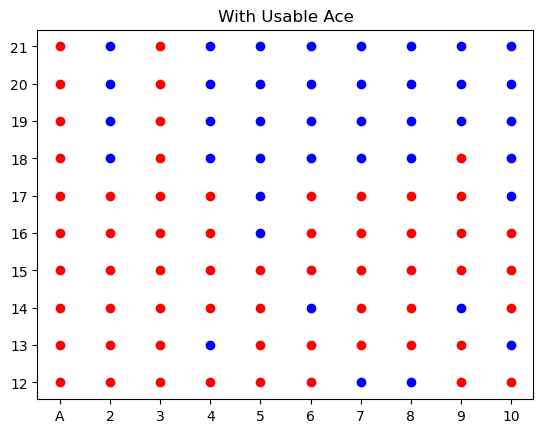

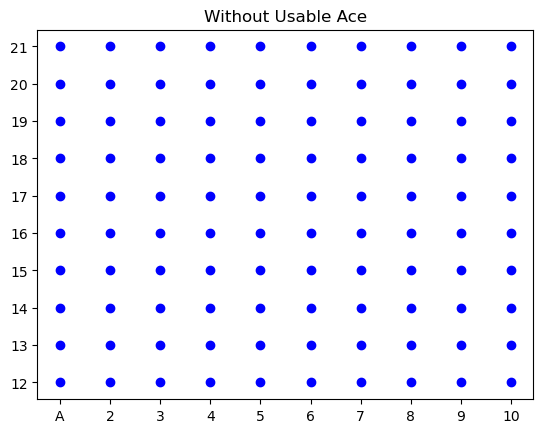

In [77]:
algo = MontoCarlo_OffPolicy(200000)
algo.run()
data_Ace,data_NoAce = algo.plot_results()